In [18]:
import random
import json_lines
from langdetect import detect_langs
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import KeyedVectors
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix

LIMIT_INPUT_ROWS= 300
MIN_ENGLISH= 0.0
WNL = WordNetLemmatizer()
REMOVEABLE_CHARS= '[^A-Za-z ]'
ALL_TAGS= ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT',
 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
 'WP$', 'WRB']
ACCEPTABLE_TAGS= ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT',
 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
 'WP$', 'WRB']
MIN_WORD_OCCURRENCES= 1
VEC_SIZE= 20
MAX_GRAMS= 4
AMOUNT_OF_FILTS= 50 # put to 100 probably

number_entries= 0
with open ('reviews.json', 'rb') as f:
    for item in json_lines.reader(f):
        number_entries+= 1

In [19]:
# READ IN INFO
reviews= []; polarity= []; are_early= []
included_indexs= []
j= 0
while j < LIMIT_INPUT_ROWS:
    randint= random.randint(0, number_entries-1)
    if not randint in included_indexs:
        included_indexs.append(randint)
        j+= 1
    
with open('reviews.json', 'rb') as f: # 5,000 entries in reviews.json
    for counter, item in enumerate(json_lines.reader(f)):
        if counter in included_indexs:
            reviews.append(item['text'])
            polarity.append(item['voted_up'])
            are_early.append(item['early_access'])

# END PRODUCTS: reviews, polarity, are_early

In [20]:
# FILTER TEXT BY CHARACTER

import re
new_reviews= []
for i, text in enumerate(reviews):
    text= re.sub(REMOVEABLE_CHARS, '', text)
    if not str.isspace(text) and text != "":
        new_reviews.append(text)
#     else:
#         print("removed ["+text+"]")
# print(reviews)
# print("########################################################################")
# print(new_reviews)
reviews= new_reviews

# END PRODUCTS: reviews

In [21]:
# FILTER TEXT BY LANGUAGE
print(reviews)

filtered_reviews= []
filtered_polarity= []
filtered_are_early= []
for i, review in enumerate(reviews):
    try:
        langs = detect_langs(review)
    except:
        print("["+review+"]")
        print("ERROR: langs failed to define itself. Happens occassionally - just rerun")
        pass
    for lang in langs:
        if str(lang)[0:2] == 'en':
            if float(str(lang)[3:]) > MIN_ENGLISH:
                filtered_reviews.append(reviews[i])
                filtered_polarity.append(polarity[i])
                filtered_are_early.append(are_early[i])
reviews= filtered_reviews
polarity= filtered_polarity
are_early= filtered_are_early
print("##################################################")
print("##################################################")
print("##################################################")
print(reviews)
# END PRODUCTS: reviews, polarity, are_early

['You have a team of champions towers and units fight by your side The job is to guide them to victory  By hand picking units and dropping them off where you want them to go If your situation doesnt go according to your plan dont worry You have miracles like sprinkling healing powder on your units or dropping ice on enemies units that you found in your freezer As time goes you are able to upgrade the team find new miracles and develop new strategies to conquer your enemies Personally I just adore the art style in this game and the hole setting that everything takes place in a mystical little shop Not too surprising for me because I like the Nimble Neurons other games too which also has a very detailed and neat art style The only negative for me is that the game is FP There will be instances where you face another player that has much stronger units because they have spent a bit of money But I still recommend this game give it a try', 'The quest for  deaths EASY', 'Ce jeu es tout simple

##################################################
##################################################
##################################################
['You have a team of champions towers and units fight by your side The job is to guide them to victory  By hand picking units and dropping them off where you want them to go If your situation doesnt go according to your plan dont worry You have miracles like sprinkling healing powder on your units or dropping ice on enemies units that you found in your freezer As time goes you are able to upgrade the team find new miracles and develop new strategies to conquer your enemies Personally I just adore the art style in this game and the hole setting that everything takes place in a mystical little shop Not too surprising for me because I like the Nimble Neurons other games too which also has a very detailed and neat art style The only negative for me is that the game is FP There will be instances where you face another player that has much s

In [23]:
# FILTER TEXT BY WORD TYPE

#print(reviews)
filtered_reviews= []
for i, text in enumerate(reviews):
    #print("-------------------------------------")
    new_text= []
    split_text= text.split()
    tags= nltk.pos_tag(split_text)
    #print(tags)
    #print("#############")
    lemd_split_text= []
    for word in split_text:
        lemd_split_text.append(WNL.lemmatize(word))
    tags= nltk.pos_tag(lemd_split_text)
    #print(tags)
    for j, word in enumerate(lemd_split_text):
        if tags[j][1] in ACCEPTABLE_TAGS:
            new_text.append(word)
    filtered_reviews.append(new_text)
reviews= [' '.join([str(elem) for elem in sublist]) for sublist in filtered_reviews]

# END PRODUCTS: reviews, polarity, are_early

In [24]:
# GET REVIEWS AS LIST OF LISTS

no_sentences= 0
reviews_as_ll= [] # ll denoting the list of list data
for text in reviews:
    split_text= text.split()
    reviews_as_ll.append(split_text)
    no_sentences+= 1

# END PRODUCTS: reviews_as_ll, no_sentences

In [25]:
# MAKE REVIEWS LOWER-CASE

for i, review in enumerate(reviews_as_ll):
    for j, word in enumerate(review):
        reviews_as_ll[i][j]= word.lower()

# END PRODUCTS: reviews_as_ll

In [28]:
# MODEL RELATED

X_train, X_test, y_train, y_test= train_test_split(reviews_as_ll, polarity, test_size=0.33, random_state=42)

model= gensim.models.Word2Vec(min_count= MIN_WORD_OCCURRENCES, vector_size=VEC_SIZE)
model.build_vocab(reviews_as_ll)
model.train(reviews_as_ll, total_examples=no_sentences, epochs=model.epochs) # can be a non-repeatable, 1-pass generator

# Store just the words + their trained embeddings.
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

print(wv['the'])
print(wv['this'])
# END PRODUCTS: wv

[-0.21006136 -0.02235295  0.21467984  0.26971227 -0.08549442 -0.23686047
  0.03874633  0.7317612  -0.400376    0.11531135  0.53851813 -0.26459405
  0.32504386 -0.03136539  0.34843352  0.45342192  0.68701524 -0.40218574
 -0.5651145  -0.71372473]
[-0.11524166  0.00178112  0.0707092   0.12186064  0.01600072 -0.07521823
 -0.01654697  0.40218538 -0.25289425  0.10511948  0.25806028 -0.15954292
  0.24451135 -0.03165968  0.24624865  0.22961381  0.4082968  -0.18097317
 -0.33405328 -0.402535  ]


In [9]:
# MAKE FILTERS

filters= []
for i in range(AMOUNT_OF_FILTS):
    filter= []
    n_gram= random.randint(2, MAX_GRAMS)
    for j in range(n_gram):
        filter_layer= []
        for k in range(VEC_SIZE):
            filter_layer.append(random.uniform(-1, 1))
        filter.append(filter_layer)
    filter= np.array([np.array(xi) for xi in filter])
    filters.append(filter)

# END PRODUCTS: filters (list of numpy.ndarray)

In [10]:
# GENERATE FEATURES
def get_activations(reviews):
    greatest_activations= {}

    for review_i, review in enumerate(reviews):
        for filt_i, filt in enumerate(filters):
            filt= filt.ravel()
            greatest_conv_value= 0
            n_gram= round(filt.size / VEC_SIZE) # round being used to convert to int
            convolutions_per_filt= len(review) - n_gram + 1
            for convolution_i in range(convolutions_per_filt):
                vec_matrix= []
                for i in range(n_gram):
                    vec_matrix.append(wv[review[convolution_i + i]]) # WV is a dict
                vec_matrix= np.array([np.array(xi) for xi in vec_matrix]).ravel() # list of lists to 1d nd numpy
                conv_result= np.convolve(filt, vec_matrix, 'valid')
                if abs(conv_result) > abs(greatest_conv_value):
                    greatest_conv_value= conv_result
            if type(greatest_conv_value) != int:
                greatest_conv_value= greatest_conv_value[0].astype(float).item()
            if type(greatest_conv_value) == int:
                greatest_conv_value= np.float64(greatest_conv_value).item()
            greatest_activations[(review_i, filt_i)]= greatest_conv_value

    amount_rows= round(len(greatest_activations) / AMOUNT_OF_FILTS)
    greatest_activations_as_ll= []
    for i in range(amount_rows):
        next_list= []
        for j in range(AMOUNT_OF_FILTS):
            next_list.append(greatest_activations[i, j])
        greatest_activations_as_ll.append(next_list)
    return greatest_activations_as_ll

train_greatst_actv= get_activations(X_train)
test_greatst_actv= get_activations(X_test)

# END PRODUCTS: greatest_activations_as_ll

overall accuracy:  0.5869565217391305


Text(0.5, 0.98, 'Confusion Matrix')

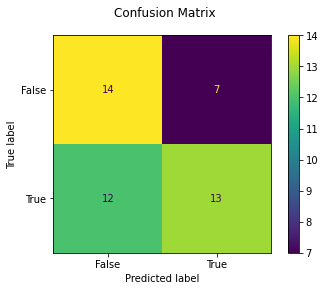

In [12]:
clf= MLPClassifier(random_state=1, max_iter=1000).fit(train_greatst_actv, y_train)
y_pred= clf.predict(test_greatst_actv)

print("overall accuracy: ", clf.score(test_greatst_actv, y_test))
fig= plot_confusion_matrix(clf, test_greatst_actv, y_test)
fig.figure_.suptitle("Confusion Matrix")